Distributed Source Coding for Machine Learning
==============================================

## Compare one and two stage encoders

In [1]:
from dsc4ml.encoders import LocalEncoder, DistributedEncoder
from dsc4ml.decoders import FusionDecoder
import xarray as xr
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'Dark2'

DA = xr.DataArray

def generate_2d_dataset(n, ρ=0.0, sep=0.0):
    μ = [1, 0]
    Σ = [[1, ρ],
         [ρ, 1]]
    w = make_normal_unit_vector(2)
    X = DA(npr.multivariate_normal(μ, Σ, size=n), dims=['n', 'd'])
    y = np.sign(X @ w)
    X += sep*y*w
    return X, y


def sample(A, dim, size):
    i_sample = npr.randint(A[dim].size, size=size)
    return A[i_sample]


def total_loss(γ):
    def curry(A, B):
        w = make_normal_unit_vector(A.sizes['d'])
        mse = np.power(A - B, 2).sum('d')
        zero_one = (np.sign(A @ w) != np.sign(B @ w))
        return (1-γ)*mse + γ*zero_one
    return curry


def make_normal_unit_vector(d) -> '(d,)':
    w = np.append(-1, np.ones(d-1))
    w = w/np.sqrt(w @ w)
    return xr.DataArray(w, dims='d')


def plot_decision_boundary(X):
    p = [X.min(), X.max()]
    plt.plot(p, p, '--', alpha=0.25)

w = make_normal_unit_vector(2)

### One-stage (prototypes $=$ codebook)

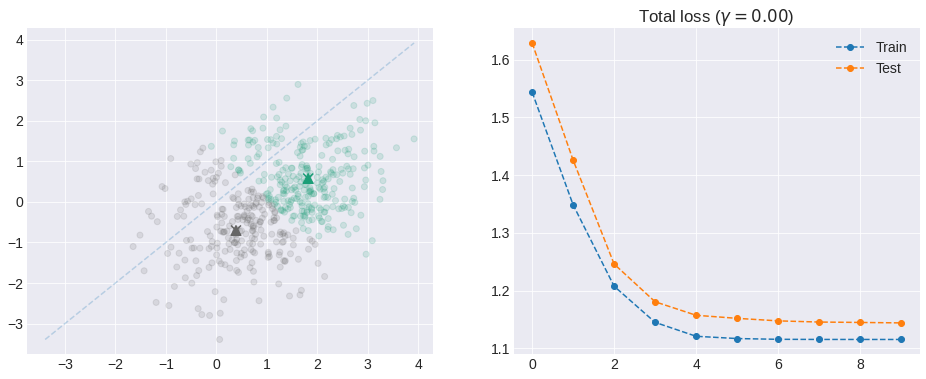

codebook:	<xarray.DataArray (m: 2, d: 2)>
		array([[ 1.8212688 ,  0.57708012],
		       [ 0.39033074, -0.70323124]])
		Coordinates:
		  * m        (m) int64 0 1
		Dimensions without coordinates: d



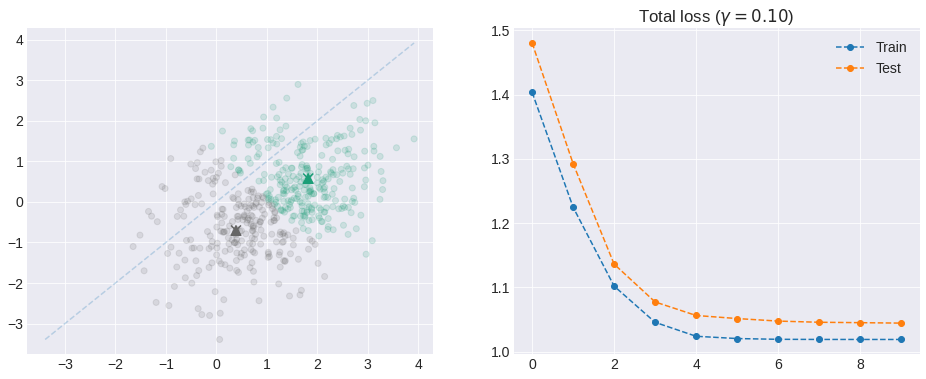

codebook:	<xarray.DataArray (m: 2, d: 2)>
		array([[ 1.8212688 ,  0.57708012],
		       [ 0.39033074, -0.70323124]])
		Coordinates:
		  * m        (m) int64 0 1
		Dimensions without coordinates: d



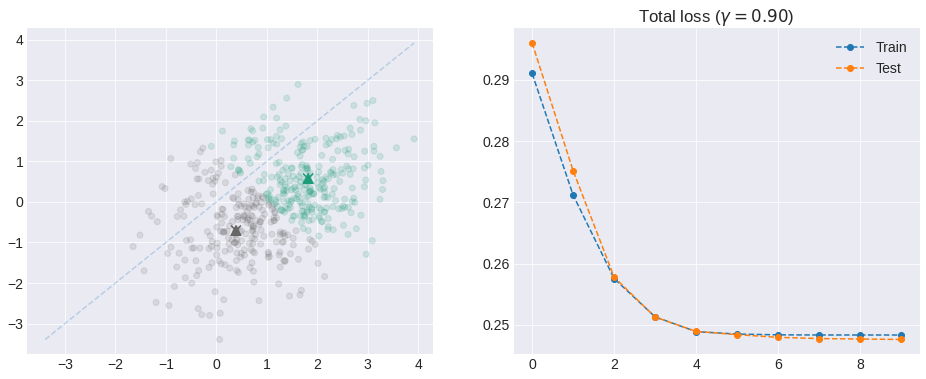

codebook:	<xarray.DataArray (m: 2, d: 2)>
		array([[ 1.8212688 ,  0.57708012],
		       [ 0.39033074, -0.70323124]])
		Coordinates:
		  * m        (m) int64 0 1
		Dimensions without coordinates: d



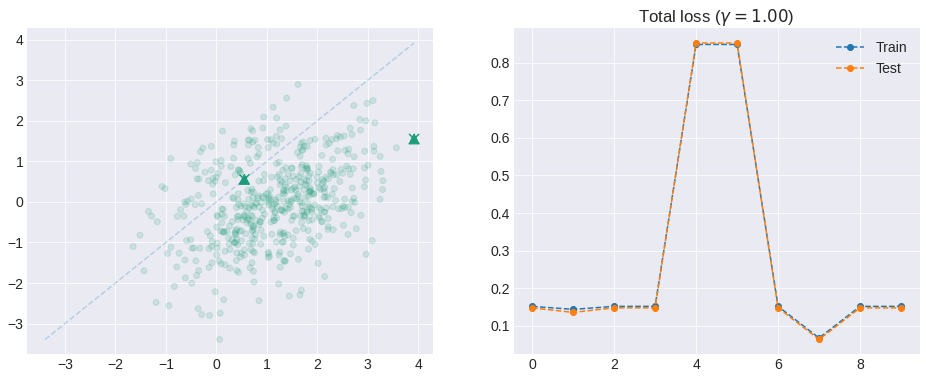

codebook:	<xarray.DataArray (m: 2, d: 2)>
		array([[0.55602195, 0.55719474],
		       [3.9198087 , 1.5537263 ]])
		Dimensions without coordinates: m, d



In [2]:
for γ in [0, 0.1, 0.9, 1.0]:
    npr.seed(0)

    X, _ = generate_2d_dataset(500, ρ=0.5, sep=0.15)
    codebook = sample(X, 'n', 2).rename(n='m')
    protos = codebook.rename(m='p')
    q_indices = DA(np.arange(2), dims='p')

    enc = LocalEncoder(protos, q_indices, rate=2)
    dec = FusionDecoder(codebook)

    losses = list()
    Z, _ = generate_2d_dataset(500, ρ=0.5, sep=0.15)
    for i in range(10):
        dec = dec.optimize(X, enc, γ, w)
        enc = (LocalEncoder(dec.codebook.rename(m='p'), q_indices, 2)
               .optimize(X, dec, total_loss(γ)))
        losses.append({'Train': total_loss(γ)(X, dec(enc(X))).mean().item(),
                       'Test': total_loss(γ)(Z, dec(enc(Z))).mean().item()})

    losses = pd.DataFrame(losses)

    plt.subplot(1, 2, 1)
    plt.scatter(*enc.protos.T, c=enc(enc.protos.rename(p='n')), marker='x', s=100)
    plt.scatter(*dec.codebook.T, c=enc(dec.codebook), marker='^', s=100)
    plt.scatter(*X.T, c=enc(X), alpha=0.15)
    plot_decision_boundary(X)

    ax = plt.subplot(1, 2, 2)
    losses.plot(ax=ax, style='o--')
    plt.title(f'Total loss ($\gamma = {γ:.2f}$)')
    plt.show()
    print(dec)

### Two-stage (prototypes $\neq$ codebook)

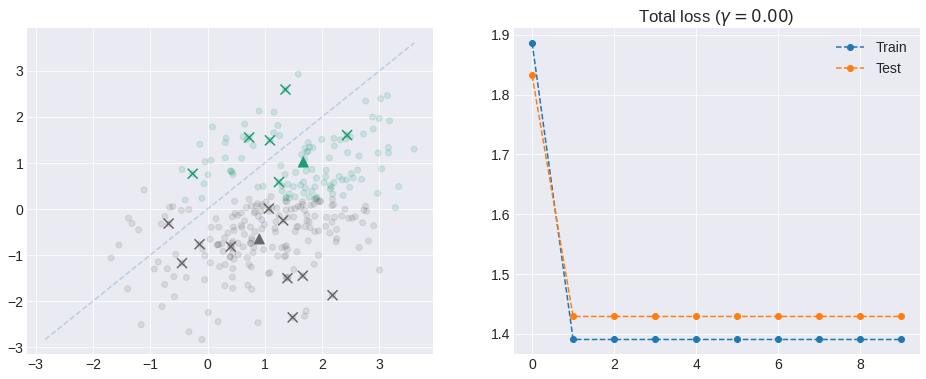

codebook:	<xarray.DataArray (m: 2, d: 2)>
		array([[ 1.67307337,  1.01986645],
		       [ 0.90427932, -0.65067256]])
		Coordinates:
		  * m        (m) int64 0 1
		Dimensions without coordinates: d



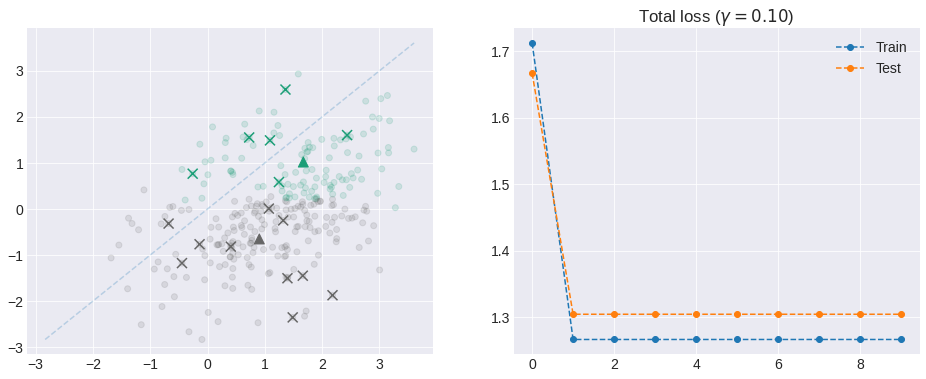

codebook:	<xarray.DataArray (m: 2, d: 2)>
		array([[ 1.67307337,  1.01986645],
		       [ 0.90427932, -0.65067256]])
		Coordinates:
		  * m        (m) int64 0 1
		Dimensions without coordinates: d



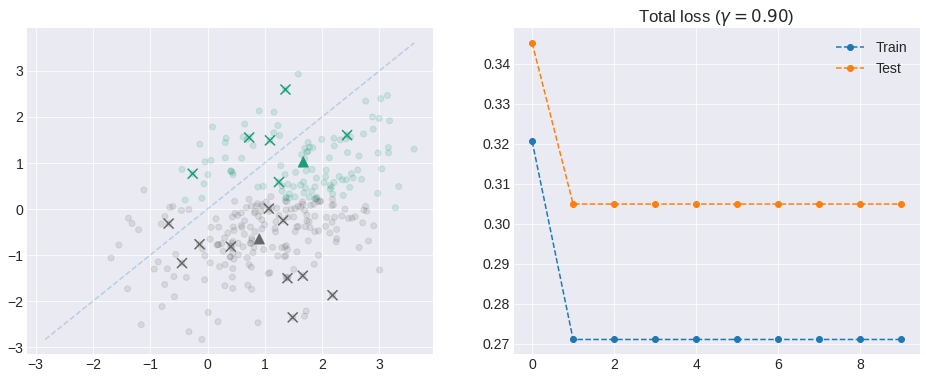

codebook:	<xarray.DataArray (m: 2, d: 2)>
		array([[ 1.67307337,  1.01986645],
		       [ 0.90427932, -0.65067256]])
		Coordinates:
		  * m        (m) int64 0 1
		Dimensions without coordinates: d



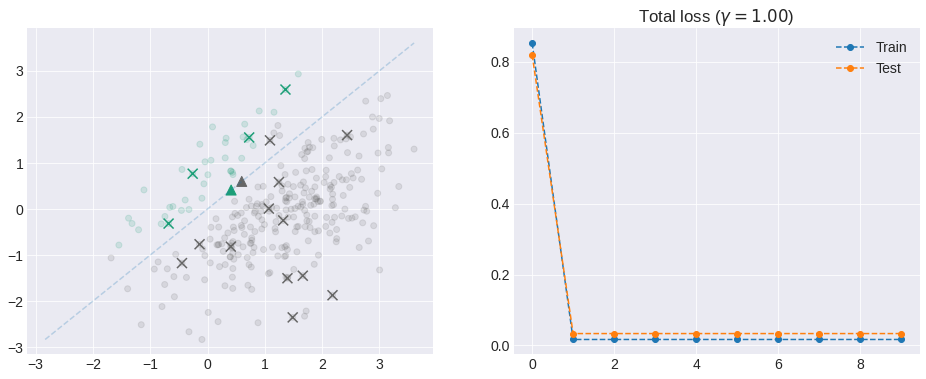

codebook:	<xarray.DataArray (m: 2, d: 2)>
		array([[0.59745239, 0.59898566],
		       [0.41245156, 0.41160826]])
		Coordinates:
		  * m        (m) int64 0 1
		Dimensions without coordinates: d



In [3]:
for γ in [0, 0.1, 0.9, 1.0]:
    npr.seed(0)

    p = 16
    X, _ = generate_2d_dataset(300, ρ=0.5, sep=0.2)
    protos = sample(X, 'n', p).rename(n='p')
    q_indices = DA(npr.randint(2, size=p), dims='p')
    codebook = sample(X, 'n', 2).rename(n='m')

    enc = LocalEncoder(protos, q_indices, rate=2)
    dec = FusionDecoder(codebook)

    losses = list()
    Z, _ = generate_2d_dataset(300, ρ=0.5, sep=0.2)
    for i in range(10):
        dec = dec.optimize(X, enc, γ, w)
        enc = enc.optimize(X, dec, total_loss(γ))
        losses.append({'Train': total_loss(γ)(X, dec(enc(X))).mean().item(),
                       'Test': total_loss(γ)(Z, dec(enc(Z))).mean().item()})

    losses = pd.DataFrame(losses)

    plt.subplot(1, 2, 1)
    plt.scatter(*enc.protos.T, c=enc(enc.protos.rename(p='n')), marker='x', s=100)
    plt.scatter(*dec.codebook.T, c=enc(dec.codebook), marker='^', s=100)
    plt.scatter(*X.T, c=enc(X), alpha=0.15)
    plot_decision_boundary(X)

    ax = plt.subplot(1, 2, 2)
    losses.plot(ax=ax, style='o--')
    plt.title(f'Total loss ($\gamma = {γ:.2f}$)')
    plt.show()
    print(dec)

## Two-stage Distributed Encoders

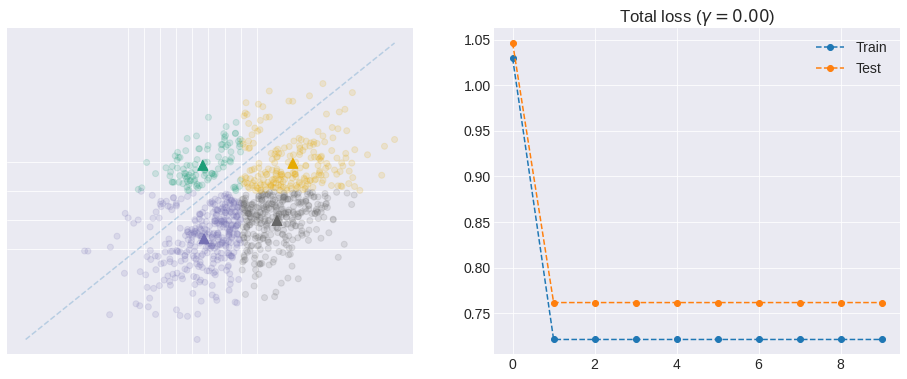

codebook:	<xarray.DataArray (m: 4, d: 2)>
		array([[ 0.21736597,  1.0308472 ],
		       [ 0.24298412, -0.85079636],
		       [ 2.07082415,  1.08186354],
		       [ 1.74375284, -0.38147161]])
		Coordinates:
		  * m        (m) int64 0 1 2 3
		Dimensions without coordinates: d



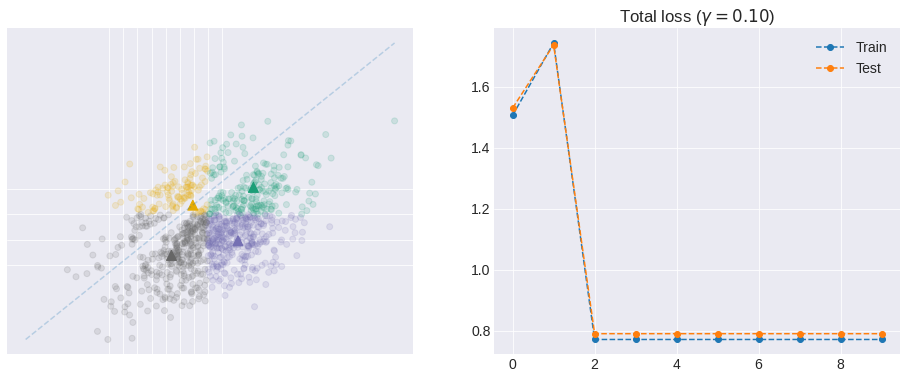

codebook:	<xarray.DataArray (m: 4, d: 2)>
		array([[ 2.07576746,  1.1663549 ],
		       [ 1.71164341, -0.40923185],
		       [ 0.64286496,  0.64202896],
		       [ 0.13761787, -0.83744681]])
		Coordinates:
		  * m        (m) int64 0 1 2 3
		Dimensions without coordinates: d



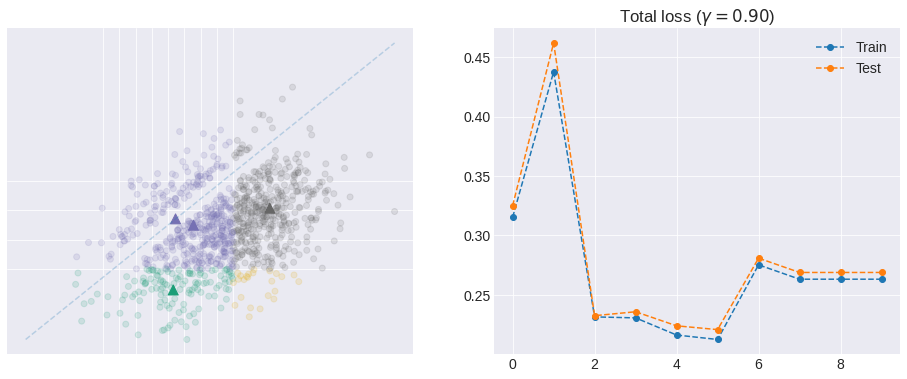

codebook:	<xarray.DataArray (m: 4, d: 2)>
		array([[ 0.10356623, -1.66040634],
		       [ 0.51762154, -0.0075808 ],
		       [ 0.15077377,  0.15414907],
		       [ 2.08407913,  0.42695849]])
		Coordinates:
		  * m        (m) int64 0 1 2 3
		Dimensions without coordinates: d



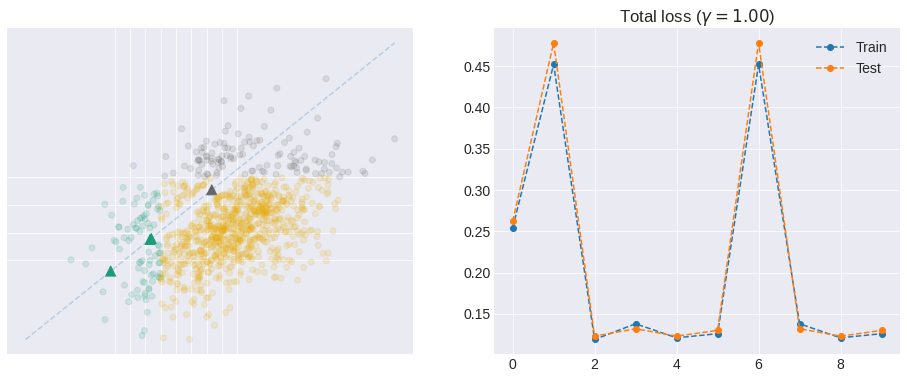

codebook:	<xarray.DataArray (m: 4, d: 2)>
		array([[ 0.78079055,  0.78198462],
		       [-0.53589137, -0.53369717],
		       [-0.5592145 , -0.56021814],
		       [-1.41703841, -1.41607794]])
		Coordinates:
		  * m        (m) int64 0 1 2 3
		Dimensions without coordinates: d



In [4]:
npr.seed(0)
for γ in [0, 0.1, 0.9, 1.0]:

    # Untreated corner cases (both will break the code):
    # - If p is too large, there will be proto-regions without points.
    # - If rate_exp is too large, some integer will be proto-region-less
    p = [10, 5]
    rate_exp = [2, 2]

    X, _ = generate_2d_dataset(1_000, ρ=0.5, sep=0.2)
    encoders = [
        LocalEncoder(DA(np.linspace(-1.5, 1.5, p[0]), dims='p').expand_dims(d=1),
                     DA(npr.randint(rate_exp[0], size=p[0]), dims='p'),
                     rate_exp[0]),

        LocalEncoder(DA(np.linspace(-1.5, 1.5, p[1]), dims='p').expand_dims(d=1),
                     DA(npr.randint(rate_exp[1], size=p[1]), dims='p'),
                     rate_exp[1])
    ]

    enc = DistributedEncoder(encoders)
    dec = FusionDecoder.init_from_encoder(X, enc, γ, w)

    losses = list()
    Z, _ = generate_2d_dataset(1_000, ρ=0.5, sep=0.2)
    for i in range(10):
        dec = dec.optimize(X, enc, γ, w)
        enc = enc.optimize(X, dec, total_loss(γ))
        losses.append({'Train': total_loss(γ)(X, dec(enc(X))).mean().item(),
                       'Test': total_loss(γ)(Z, dec(enc(Z))).mean().item()})

    losses = pd.DataFrame(losses)

    plt.subplot(1, 2, 1)
    plt.scatter(*dec.codebook.T, c=enc(dec.codebook), marker='^', s=100)
    plt.scatter(*X.T, c=enc(X), alpha=0.15)
    plt.xticks(enc[0].boundaries.round(2), '')
    plt.yticks(enc[1].boundaries.round(2), '')
    plot_decision_boundary(X)

    ax = plt.subplot(1, 2, 2)
    losses.plot(ax=ax, style='o--')
    plt.title(f'Total loss ($\gamma = {γ:.2f}$)')
    plt.show()
    print(dec)

```{toctree}
:hidden:
:titlesonly:


.pytest_cache/README
dsc4ml/decoders
```